In [2]:
import pandas as pd
import numpy as np

# Hela ML libraries 
from hela import hmm
import hela.generation.hmm as hmm_gen

# Viz libraries
import altair as alt
import hela.visualization.hmm as hmmplot 
import matplotlib.pyplot as plt
from hela.visualization.hmm import TU_COLORS
%matplotlib inline

# Utility Libraries
from datetime import datetime
from dask.distributed import Client
from scipy.special import logsumexp
from scipy import stats
import itertools
from IPython.display import Image

# PGMPy
from hela.hmm.graphical_models import DynamicBayesianNetwork as dbn
from hela.hmm.graphical_models import structured_inference as dbn_inf
from hela.hmm.graphical_models import ContinuousFactor as cont_factor
from pgmpy.factors.discrete import TabularCPD


/opt/conda/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


### FHMM Model

In [2]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2, 2, 2],
                                     n_gaussian_features = 0,
                                     n_categorical_features = 2)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)

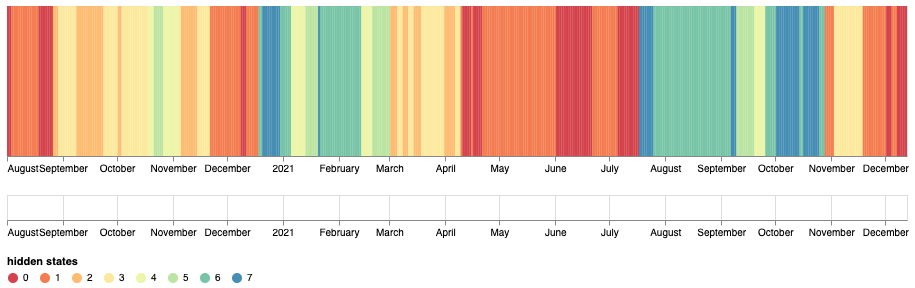

In [3]:
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)
hmmplot.draw_states(flattened_hidden_states, hide_brush=False)

In [4]:
fhmm_data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   fhmm_data,
                                   categorical_features = list(gen.categorical_values.columns), 
                                   gaussian_features = [])

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

fhmm_model = fhmm_config.to_model()

### PGMpy Structure of FHMM

For the edge factors in an FHMM graph, each transition arrow is defined by the corresponding transition matrix for that system.  For categorical data, we define the marginalized emission probability for each emission edge.  For continous data, the edge is defined by the W matrix and covariance matrix.  In the learning/inference process these will be used to generate the pdf for a given hs vector.

In [5]:
for node in fhmm_model.graph.nodes:
    print("latent status for node {} at time step {}: ".format(node[0], node[1]), 
          fhmm_model.graph.nodes[node])

latent status for node system_0 at time step 0:  {'latent': True}
latent status for node system_0 at time step 1:  {'latent': True}
latent status for node system_1 at time step 0:  {'latent': True}
latent status for node system_1 at time step 1:  {'latent': True}
latent status for node system_2 at time step 0:  {'latent': True}
latent status for node system_2 at time step 1:  {'latent': True}
latent status for node cat_obs at time step 0:  {'latent': False}
latent status for node cat_obs at time step 1:  {'latent': False}


In [6]:
fhmm_model.graph.edges()

OutEdgeView([(('system_0', 0), ('system_0', 1)), (('system_0', 0), ('cat_obs', 0)), (('system_0', 1), ('cat_obs', 1)), (('system_1', 0), ('system_1', 1)), (('system_1', 0), ('cat_obs', 0)), (('system_1', 1), ('cat_obs', 1)), (('system_2', 0), ('system_2', 1)), (('system_2', 0), ('cat_obs', 0)), (('system_2', 1), ('cat_obs', 1))])

In [7]:
fhmm_model.graph.check_model()

True

In [8]:
fhmm_model.graph.get_factors(time_slice=0)


[[<TabularCPD representing P(('cat_obs', 0):6 | ('system_0', 0):2) at 0x7f40448c8828>,
  <TabularCPD representing P(('cat_obs', 0):6 | ('system_1', 0):2) at 0x7f404481cc50>,
  <TabularCPD representing P(('cat_obs', 0):6 | ('system_2', 0):2) at 0x7f404481c518>],
 [<TabularCPD representing P(('system_0', 0):2) at 0x7f40448c87b8>],
 [<TabularCPD representing P(('system_1', 0):2) at 0x7f404481c550>],
 [<TabularCPD representing P(('system_2', 0):2) at 0x7f404481c4e0>]]

In [9]:
fhmm_model.graph.get_factors(time_slice=1)

[[<TabularCPD representing P(('cat_obs', 1):6 | ('system_0', 1):2) at 0x7f40448c86a0>,
  <TabularCPD representing P(('cat_obs', 1):6 | ('system_1', 1):2) at 0x7f404481c3c8>,
  <TabularCPD representing P(('cat_obs', 1):6 | ('system_2', 1):2) at 0x7f404484b5c0>],
 [<TabularCPD representing P(('system_0', 1):2 | ('system_0', 0):2) at 0x7f40448c82b0>],
 [<TabularCPD representing P(('system_1', 1):2 | ('system_1', 0):2) at 0x7f40448c8668>],
 [<TabularCPD representing P(('system_2', 1):2 | ('system_2', 0):2) at 0x7f404482f518>]]

### Structured Variational Inference

We break up each of the Markov systems in the fHMM graph and run the forward backward algorithm in each of the systems


TODO: add in variational parameter + checking for convergence

In [10]:
system_graphs = fhmm_model.graph.generate_system_graphs()

In [11]:
for graph in system_graphs:
    assert graph.check_model()
    print(graph.get_latent_nodes(time_slice=0))

[('system_0', 0)]
[('system_1', 0)]
[('system_2', 0)]


In [12]:
system_graphs[2].factors

[<TabularCPD representing P(('system_2', 1):2 | ('system_2', 0):2) at 0x7f404482f518>,
 <TabularCPD representing P(('system_2', 0):2) at 0x7f404481c4e0>,
 <TabularCPD representing P(('cat_obs', 0):6 | ('system_2', 0):2) at 0x7f404481c518>,
 <TabularCPD representing P(('cat_obs', 1):6 | ('system_2', 1):2) at 0x7f404484b5c0>]

In [13]:
# def get_system(node):
#     return int(node[0][-1])

In [14]:
# def create_variational_graph(graph):
#     graph.factors = [factor for factor in graph.factors 
#                            if not isinstance(factor, cont_factor.ContinuousFactor)]
    
# #     observation_nodes = graph.get_observable_nodes()
# #     graph.remove_nodes_from(observation_nodes)
#     system = get_system(graph.get_latent_nodes(time_slice=0))
#     var_nodes = [('h_{system}'.format(system=system), i) for i in range(2)]
#     graph.add_nodes_from(var_nodes, latent=[False] * len(var_nodes))
#     graph.add_edges_from(list(zip(graph.get_latent_nodes(), var_nodes)))
#     cardinality = graph.factors[0].cardinality[0]
#     variational_factor = (np.ones(cardinality)/len(np.ones(cardinality))).reshape(cardinality, 1)
#     h0_evidence = graph.get_latent_nodes(time_slice=0)
#     h1_evidence = graph.get_latent_nodes(time_slice=1)
#     h0_cpd = TabularCPD(
#             var_nodes[0],
#             cardinality,
#             variational_factor)
# #             evidence=h0_evidence,
# #             evidence_card = np.ones(cardinality))
#     h1_cpd = TabularCPD(
#             var_nodes[1],
#             cardinality,
#             variational_factor)
# #             evidence=h1_evidence,
# #             evidence_card = np.ones(cardinality))
#     graph.add_factors(*[h0_cpd, h1_cpd])
    
#     return graph

In [15]:
# variational_graphs = [create_variational_graph(graph) for graph in system_graphs]

In [16]:
# for graph in variational_graphs:
#     print('latent nodes:', graph.get_latent_nodes())
#     print('observable nodes:', graph.get_observable_nodes())
#     print('edges:', graph.edges)
#     assert graph.check_model()

In [17]:
inference = dbn_inf.DBNInference(system_graphs[0])
probability = inference.forward_backward(fhmm_data)

Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 44.85it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 57.27it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 380.30it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 199.92it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 327.07it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 210.01it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 169.89it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 110.39it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 216.06it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 96.99it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 129.43it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 69.48it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 77.48it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 92.09it/s]


Eliminating: ('system_0', 0): 100%|██████████| 1/1 [00:00<00:00, 122.59it/s]
/opt/conda/lib/python3.7/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:788: RuntimeWarning: invalid value encountered in true_divide
  phi.values = phi.values / phi1.values


In [18]:
probability

array([[9.99999789e-01, 2.10870605e-07],
       [9.99999448e-01, 5.51526882e-07],
       [9.99995575e-01, 4.42467409e-06],
       [9.99990301e-01, 9.69936853e-06],
       [9.99983752e-01, 1.62477274e-05],
       [9.99949275e-01, 5.07248639e-05],
       [9.99960807e-01, 3.91930901e-05],
       [9.99963473e-01, 3.65266934e-05],
       [9.99959747e-01, 4.02529437e-05],
       [9.99949109e-01, 5.08906385e-05],
       [9.99928619e-01, 7.13813736e-05],
       [9.99892267e-01, 1.07732775e-04],
       [9.99829212e-01, 1.70787830e-04],
       [9.99720345e-01, 2.79654809e-04],
       [9.82948440e-01, 1.70515603e-02],
       [9.93767507e-01, 6.23249288e-03],
       [9.97619179e-01, 2.38082112e-03],
       [9.99620837e-01, 3.79162904e-04],
       [9.99888067e-01, 1.11933357e-04],
       [9.92413540e-01, 7.58645951e-03],
       [9.99588401e-01, 4.11599025e-04],
       [9.99973139e-01, 2.68614288e-05],
       [9.99996718e-01, 3.28165816e-06],
       [9.99998443e-01, 1.55653141e-06],
       [9.999971

In [3]:
gen = hmm_gen.FactoredHMMGenerativeModel(
                                     ns_hidden_states =[2, 2, 2],
                                     n_gaussian_features = 2,
                                     n_categorical_features = 0)

factored_hidden_states = gen.generate_hidden_state_sequence(n_observations = 500)
flattened_hidden_states = gen.flatten_hidden_state_sequence(factored_hidden_states)

fhmm_data = gen.generate_observations(factored_hidden_states)
fhmm_training_spec = hmm_gen.data_to_fhmm_training_spec(factored_hidden_states, 
                                   gen.ns_hidden_states, 
                                   fhmm_data,
                                   categorical_features = [], 
                                   gaussian_features = list(gen.gaussian_values.columns))

fhmm_config = hmm.FactoredHMMConfiguration.from_spec(fhmm_training_spec)

fhmm_model = fhmm_config.to_model()

In [29]:
system_graphs = fhmm_model.graph.generate_system_graphs()

In [30]:
graph = system_graphs[0]
cardinality = graph.factors[0].cardinality[0]
factors = [factor for factor in graph.factors if not isinstance(factor, cont_factor.ContinuousFactor)]
nodes = graph.get_observable_nodes()
graph.factors = factors
graph.remove_nodes_from(nodes)

In [31]:
graph.nodes

NodeView((('system_2', 0), ('system_2', 1)))

In [32]:
graph.edges

OutEdgeView([(('system_2', 0), ('system_2', 1))])

In [33]:
graph.add_nodes_from([('var', 0), ('var', 1)], latent=[False, False])

In [34]:
graph.add_edges_from([(('system_2', 0), ('var', 0)), (('system_2', 0),('var', 1))])

In [35]:
init_var = np.ones(cardinality)/cardinality

In [36]:
init_var.reshape(1,-1).ndim

2

In [37]:
variational_factor0 = TabularCPD(
            ('var', 0),
            1,
            init_var.reshape(1,-1),
            evidence=[('system_2', 0)],
            evidence_card=[cardinality])

In [38]:
variational_factor1 = TabularCPD(
            ('var', 1),
            1,
            init_var.reshape(1,-1),
            evidence=[('system_2', 1)],
            evidence_card=[cardinality])

In [39]:
graph.factors.extend([variational_factor0, variational_factor1])
graph.initialize_initial_state()

In [40]:
graph.nodes()

NodeView((('system_2', 0), ('system_2', 1), ('var', 0), ('var', 1)))

In [41]:
inference = dbn_inf.DBNInference(graph)


observation_node = inference.model.get_observable_nodes()[0][0]
variables = [(system, i) for i in range(1,len(fhmm_data))]
inference.model.initialize_initial_state()

forward = inference.forward_inference(variables)

ValueError: Self loops are not allowed

In [158]:
fhmm_data

,gaussian_feature_0,gaussian_feature_1
2020-08-01,-2.345496,5.328429
2020-08-02,-5.588038,4.929305
2020-08-03,-5.565526,3.916521
2020-08-04,-6.034091,4.069124
2020-08-05,-0.755909,4.709541
...,...,...
2021-12-09,-6.400611,-0.045514
2021-12-10,-5.555538,2.296491
2021-12-11,-6.770326,1.733200
2021-12-12,-6.588634,-0.074614


In [133]:
graph.nodes()

NodeView((('system_0', 0), ('system_0', 1), ('var', 0), ('var', 1), ('hs', 0), ('hs', 1)))

In [102]:
systems = set([node[0] for node in fhmm_model.graph.get_latent_nodes()])
latent_nodes = fhmm_model.graph.get_latent_nodes()
for i, graph in enumerate(system_graphs):
    other_graphs = [(j, system_graphs[j]) for j in range(len(system_graphs)) if i != j]
    print(other_graphs)
    weights = [[(other_graph[0], factor.weights) for factor in other_graph[1].factors if 
                    isinstance(factor, cont_factor.ContinuousFactor)] for other_graph in other_graphs]
    
    
weights[0][0]

[(1, <hela.hmm.graphical_models.DynamicBayesianNetwork.DynamicBayesianNetwork object at 0x7f4042dcdcf8>), (2, <hela.hmm.graphical_models.DynamicBayesianNetwork.DynamicBayesianNetwork object at 0x7f4042e16c18>)]
[[(1, array([[-1.51664612, -1.43246113],
       [ 0.17841132,  3.61892342]])), (1, array([[-1.51664612, -1.43246113],
       [ 0.17841132,  3.61892342]]))], [(2, array([[-4.67447382,  0.02292256],
       [ 3.11018118,  1.5557365 ]])), (2, array([[-4.67447382,  0.02292256],
       [ 3.11018118,  1.5557365 ]]))]]
[(0, <hela.hmm.graphical_models.DynamicBayesianNetwork.DynamicBayesianNetwork object at 0x7f4042dcd828>), (2, <hela.hmm.graphical_models.DynamicBayesianNetwork.DynamicBayesianNetwork object at 0x7f4042e16c18>)]
[[(0, array([[ 0.268345  , -2.76161056],
       [ 1.67304478,  2.32984813]])), (0, array([[ 0.268345  , -2.76161056],
       [ 1.67304478,  2.32984813]]))], [(2, array([[-4.67447382,  0.02292256],
       [ 3.11018118,  1.5557365 ]])), (2, array([[-4.67447382,  0.02

(0, array([[ 0.268345  , -2.76161056],
        [ 1.67304478,  2.32984813]]))

In [26]:
for factor in system_graphs[0].factors:
    if isinstance(factor, cont_factor.ContinuousFactor):
        print(factor.weights)

[[ 0.268345   -2.76161056]
 [ 1.67304478  2.32984813]]
[[ 0.268345   -2.76161056]
 [ 1.67304478  2.32984813]]


In [37]:
for system 

fhmm_data.values[1] - np.dot(probability[0], factor.weights)

array([-5.85638343,  7.6909143 ])

In [38]:
for graph in system_graphs:
    print(graph.factors)

[<TabularCPD representing P(('system_0', 1):2 | ('system_0', 0):2) at 0x7f4042bd5b00>, <TabularCPD representing P(('system_0', 0):2) at 0x7f4042bd5e80>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f4042bd5860>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f4042bd54a8>]
[<TabularCPD representing P(('system_1', 1):2 | ('system_1', 0):2) at 0x7f4042bd55c0>, <TabularCPD representing P(('system_1', 0):2) at 0x7f404299cba8>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f404299cb70>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f404299cc88>]
[<TabularCPD representing P(('system_2', 1):2 | ('system_2', 0):2) at 0x7f404299c6d8>, <TabularCPD representing P(('system_2', 0):2) at 0x7f404299c828>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f404299c908>, <hela.hmm.graphical_models.ContinuousFactor.ContinuousFactor object at 0x7f404299ca20>]


In [57]:
for item in list(zip(observable_nodes, latent_nodes)):
    print(list(item))

[('cont_obs', 0), ('system_0', 0)]
[('cont_obs', 1), ('system_0', 1)]


In [50]:
observable_nodes

{('cont_obs', 0), ('cont_obs', 1)}

In [61]:
factor_variables = [list(item) for item in zip(observable_nodes, latent_nodes)]
factor_variables

[[('cont_obs', 0), ('system_0', 0)], [('cont_obs', 1), ('system_0', 1)]]

In [62]:
for factor in system_graphs[0].factors:
    if factor.variables in factor_variables:
        print(factor)

In [66]:
factor_variables = [list(variables) for variables in zip(observable_nodes, latent_nodes)]
factor = [factor for factor in system_graphs[0].factors if factor.variables in factor_variables][0]
factor.weights

array([[ 0.268345  , -2.76161056],
       [ 1.67304478,  2.32984813]])

In [74]:
latent_nodes = fhmm_model.graph.get_latent_nodes()
for graph in system_graphs:
    removable_nodes = set([node for node in latent_nodes if node not in graph])
    print(removable_nodes)

{('system_1', 1), ('system_2', 0), ('system_2', 1), ('system_1', 0)}
{('system_2', 1), ('system_0', 0), ('system_0', 1), ('system_2', 0)}
{('system_1', 1), ('system_0', 0), ('system_0', 1), ('system_1', 0)}


In [72]:
[node[0] for node in latent_nodes]

['system_0', 'system_0', 'system_1', 'system_1', 'system_2', 'system_2']